Final Project of Machine Learning course.
Machine recognition of hand-written characters.
By Mario Jiménez and Manuel Hernández

In this project we are facing the challenge of recognizing hand-written digits vía Machine Learning

We will use a standard multi-class classification Neural Network with 3 layers (input, hidden, output) to clasify 8x8 input images.

Input images are, at start, 32 x 32 normalized bitmaps with pixel values 0 or 1 (0 for non written and 1 for written). Those are then divided into 4x4 non interpolated regions which give the result 8x8 images with pixel values from 0 to 16. 

Those 8x8 images are the ones we will work with.

In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import csv
import scipy.optimize as opt

In [157]:
def displayData(X):
    num_plots = int(np.size(X, 0)**.5)
    fig, ax = plt.subplots(num_plots, num_plots, sharex=True, sharey=True)
    plt.subplots_adjust(left=0, wspace=0, hspace=0)
    img_num = 0
    for i in range(num_plots):
        for j in range(num_plots):
            # Convert column vector into 20x20 pixel matrix
            # transpose
            img = X[img_num, :].reshape(8, 8).T
            ax[i][j].imshow(img, cmap='Greys')
            ax[i][j].set_axis_off()
            img_num += 1

    return (fig, ax)

def displayImage(im):
    fig2, ax2 = plt.subplots()
    image = im.reshape(8, 8)
    ax2.imshow(image, cmap='gray')
    return (fig2, ax2)

# Logistic Regresion Functions


In [210]:
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

def hipotesis (thetas, X):
    thetas = np.array(thetas)[np.newaxis]
    return sigmoid(X.dot(thetas))

# Regularized gradient descent
def alg_desGrad_reg(thetas, X, Y, _lambda):
    H = np.array(sigmoid(X.dot(thetas)))[np.newaxis] 
    print(H.shape, "-", Y.shape)
    
    
    print((X.T*(1/len(X))).shape , "AAA")
    return (np.dot((1.0/len(X)), X.T).dot(H.T-Y))+(_lambda/len(X))*thetas

def costFunc_reg(thetas, X, Y, _lambda):
    H = sigmoid(X.dot(thetas))
    oper1 = -(float(1)/len(X))
    oper2 = np.dot((np.log(H)).T, Y)
    oper3 = (np.log(1-H)).T
    oper4 = 1-Y
    oper5 = (_lambda/(2*len(X)))*np.sum(thetas**2)
    return (oper1 * (oper2 + np.dot(oper3, oper4)))+ oper5

def oneVsAll(X, Y, num_etiquetas, reg):
    thetas = np.zeros((num_etiquetas, X.shape[1])) #Thetas es un vector de shape (num_etiquetas, 401)
    for i in range(num_etiquetas):
        a = (Y == i)*1
        thetas[i] = opt.fmin_tnc(costFunc_reg, thetas[i], alg_desGrad_reg, args = (X, a, reg))[0]
        
    return thetas

We start getting the data:

In [211]:
file = open('Data/optdigits.tra', encoding ="utf8", errors = "ignore")
data = csv.reader(file)
lines = np.array(list(data))

X_input = np.array(lines[:,:-1], dtype = np.int)
Y_input = np.array(lines [:,-1:], dtype = np.int)


X_m = np.hstack([np.ones((len(X_input),1)),X_input])
thetas = np.zeros(len(X_m[0]))

numCases = len (X_input)
numTags = len(np.unique(Y_input))


no_tags = 10
reg = 0.1

print(costFunc_reg(thetas, X_m, Y_input, 1))

thetas_opt = oneVsAll(X_m, Y_input, no_tags, reg)
resultados = hipotesis(thetas_opt.T, X_m) 

[0.69314718]
(1, 3823) - (3823, 1)
(65, 3823) AAA


ValueError: tnc: invalid gradient vector from minimized function.

# Neural Network Functions

## Activation Functions

In [50]:
#Used as activation function with Neural nertworks
def sigmoid (z):
    return 1.0/(1.0 + np.exp(-z))

def sigmoidDerivative(z):
    return sigmoid(z)*(1-sigmoid(z))

def arctan(z):
    return np.arctan(z)

def arctanDerivative(z):
    return 1/(np.power(z, 2) +1)

## Propagation and cost

In [76]:
#hypothesis function for a 3 layer neuronal network
def forwardProp(thetas1, thetas2, X, activationF):
    z2 = thetas1.dot(X.T)
    a2 = activationF(z2)
    tuple = (np.ones(len(a2[0])), a2)
    a2 = np.vstack(tuple)
    z3 = thetas2.dot(a2)
    a3 = activationF(z3)
    return z2, a2, z3, a3

def backprop(params_rn, num_inputs, num_hidden, num_tags, X, Y, reg, activationF, activationF_der):
    # Parameter reshaping
    th1 = np.reshape(params_rn[:num_hidden *(num_inputs + 1)],(num_hidden, (num_inputs+1)))
    th2 = np.reshape(params_rn[num_hidden*(num_inputs + 1): ], (num_tags,(num_hidden+1)))
    
    # Input layer with the bias term
    X_m = np.hstack([np.ones((len(X), 1), dtype = np.float), X])
    # M is the number of elements in the test set
    m = len(X)
    y = np.zeros((m, num_tags))
    
    # Y matrix takes (nElements, nTags) form
    # Each row is full of 0s except the element which represents, that will be 1
    y = np.zeros((m, num_tags))
    for i in range(len(Y)):
        y[i][Y[i]] = 1
    
    # Cost calculation with the cost Function (regularized)
    cost = costFun(X_m, y, th1, th2, reg, activationF)
    
    # Forward propagation
    z2, a2, z3, a3 = forwardProp(th1, th2, X_m, activationF)

    delta3 = np.array(a3 - y.T)    #(numtags, nElements)
    delta2 = (th2.T.dot(delta3))[1: , :] * activationF_der(z2)  #(2layer, nElements)

    gradW1 = np.zeros(th1.shape)
    gradW2 = np.zeros(th2.shape)


    gradW1 = gradW1 + (delta2.dot(X_m))
    gradW2 = gradW2 + (delta3.dot(a2.T))

    reg1 = (reg/m)*th1
    reg2 = (reg/m)*th2


    gradW1 = (gradW1/m) + reg1
    gradW2 = (gradW2/m) + reg2

    return cost, np.concatenate((gradW1, gradW2), axis = None) 

#Cost Function
def costFun(X, y, theta1, theta2,  reg, activationF):
    #Here we assert that we can operate with the parameters
    X = np.array(X)
    y = np.array(y)
    m = len(y)

    theta1 = np.array(theta1)
    theta2 = np.array(theta2)

    hipo  = forwardProp(theta1, theta2, X, activationF)[3]
    cost = np.sum((-y.T)*(np.log(hipo)) - (1-y.T)*(np.log(1- hipo)))/m

    regcost = np.sum(np.power(theta1[:, 1:], 2)) + np.sum(np.power(theta2[:,1:], 2))
    regcost = regcost * (reg/(2*m))

    return cost + regcost

def initializeWeights(L_in, L_out):
    cini = 0.012
    aux = np.random.uniform(0.001, cini, size =(L_in, L_out))
    aux = np.insert(aux,0,1,axis = 0)
    return aux

Here we obtain the data to use it. It comes in an (Ncases, 64) array. 
Each case consists of 64 values from 0 to 16.
Then, we normalize it to the interval [0.0, 1.0]
Y array comes in form (Ncases, 1).Each value in Y is between 0 and 9. Indicating which number is written.
To operate with it, Y must be converted to a (nCases, nClases) array. 
Each row will contain 10 values. All set to 0 except the case that is true for that number. E.g. If the number written is '0', `Y[0]` will be `true` and the rest will be `false`

<IPython.core.display.Javascript object>


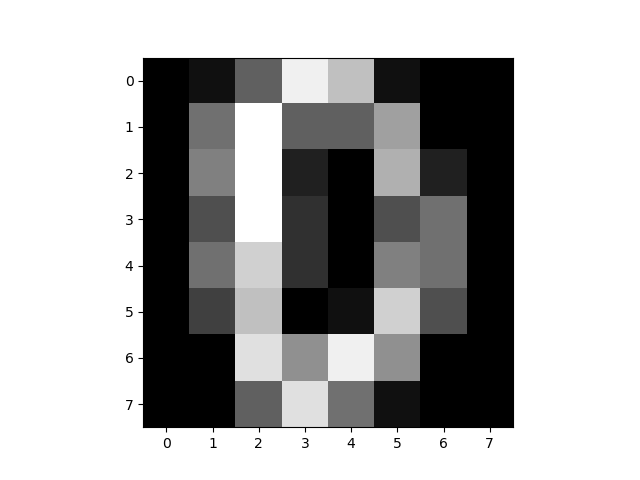

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2d0e63d7e48>)

In [70]:
file = open('Data/optdigits.tra', encoding ="utf8", errors = "ignore")
data = csv.reader(file)
lines = np.array(list(data))

X_input = np.array(lines[:,:-1], dtype = np.int)
Y_input = np.array(lines [:,-1:], dtype = np.int)

numCases = len (X_input)
numTags = len(np.unique(Y_input))

#X matrix with normalized values from [0, 16] to [0.0, 1.0]

X_N = X_input/16.0
Y_real = np.zeros((numCases, numTags), dtype = np.int)
for n in range(numCases):
    Y_real[n][Y_input[n]] = 1
    
displayImage(X_N[0])


After some research we decided we will be operating with a 3 layer NN
We will be operating a 3 layer NN. 
- 1 input layer
- 1 hidden layer
- 1 output layer

In [71]:
#Loading the testSet
file = open('Data/optdigits.tes', encoding ="utf8", errors = "ignore")
data = csv.reader(file)
lines = np.array(list(data))

testSet_X = np.array(lines[:,:-1], dtype = np.int)
testSet_Y = np.array(lines [:,-1:], dtype = np.int)

In [72]:
# Function to train our Neural Network
def trainNN(no_inputs, no_hidden, no_tags, iterations, reg, X_input, Y_input, theta1, theta2, activationF, activationF_der):
    params = np.hstack((np.ravel(theta1), np.ravel(theta2)))
    
    theta1 = np.array(theta1)
    theta2 = np.array(theta2)
    
    out = opt.minimize(fun = backprop, x0 = params, args = (no_inputs, no_hidden, no_tags, X_input, Y_input, reg, activationF, activationF_der), method='TNC', jac = True, options = {'maxiter': iterations})

    Th1 = out.x[:(no_hidden*(no_inputs+1))].reshape(no_hidden,(no_inputs+1))
    Th2 = out.x[(no_hidden*(no_inputs+1)):].reshape(no_tags,(no_hidden+1))
    
    return Th1, Th2
    

#Function to test our neural network over some test Set
def testNN(Thetas1, Thetas2, testSet_X, testSet_Y, activationF):
    
    inpu = np.hstack([np.ones((len(testSet_X), 1), dtype = np.float), testSet_X])
    hipo = forwardProp(Thetas1, Thetas2, inpu, activationF)[3]
    Ghipo = np.array((hipo.argmax(axis = 0)))[np.newaxis]
    Ghipo = Ghipo.T
    prec = (Ghipo == testSet_Y)*1
    precision = np.sum(prec) / len(testSet_X)
    print("Program precision: ", precision *100, "%")
    
    return int(precision*100)


Program precision:  19.977740678909292 %
Program precision:  28.26933778519755 %
Program precision:  59.654980523094046 %
Program precision:  71.61936560934892 %
Program precision:  79.18753478018921 %
Program precision:  83.41680578742348 %
Program precision:  85.36449638286032 %
Program precision:  85.920979410128 %
Program precision:  86.64440734557596 %
Program precision:  88.53644963828603 %
Program precision:  88.75904284919311 %


<IPython.core.display.Javascript object>


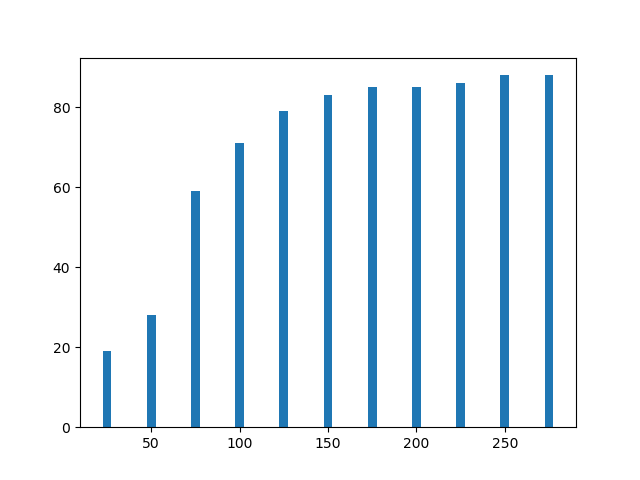

In [36]:
no_inputs = 64
no_tags = 10
no_hidden = 20
iterations = 50
reg = 1
activation = sigmoid
activation_Der = sigmoidDerivative

iters = np.arange(25, 300, 25, dtype = np.int)

t1 = initializeWeights(no_inputs, no_hidden)
t2 = initializeWeights(no_hidden, no_tags)
Y_it = np.zeros(len(iters))


j = 0
for i in iters:
    W1, W2 = trainNN(no_inputs, no_hidden, no_tags, i, reg, X_input, Y_input, t1, t2, activation, activation_Der)
    Y_it[j] = (testNN(W1, W2, testSet_X, testSet_Y, activation))
    j = j+1


plt.figure()
fig = plt.bar(iters, Y_it, width = 5)
plt.savefig("sigmoid_precision_iterations")
plt.show()


C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in log


Program precision:  10.239287701725097 %
Program precision:  13.132999443516974 %
Program precision:  3.5058430717863103 %
Program precision:  7.846410684474124 %
Program precision:  11.185308848080133 %
Program precision:  10.573177518085698 %
Program precision:  7.846410684474124 %
Program precision:  9.515859766277128 %
Program precision:  10.35058430717863 %
Program precision:  11.519198664440735 %
Program precision:  8.625486922648859 %
Program precision:  15.748469671675014 %
Program precision:  10.01669449081803 %
Program precision:  9.794101279910963 %
Program precision:  6.3995548135781855 %


<IPython.core.display.Javascript object>


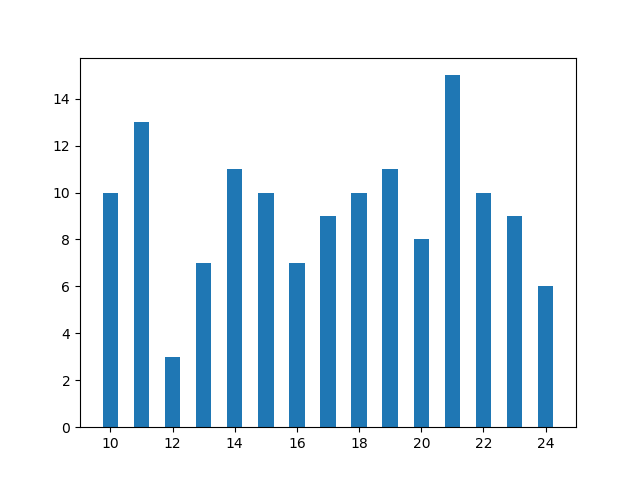

In [67]:
activation = sigmoid
activation_Der = sigmoidDerivative
no_inputs = 64
no_tags = 10
no_hidden = 20
iterations = 50
reg = 1

hids = np.arange(10, 25, 1, dtype = np.int)
Y_hid = np.zeros(len(hids))

x = 0
for y in hids:
    t1 = initializeWeights(no_inputs, y)
    t2 = initializeWeights(y, no_tags)
    W1, W2 = trainNN(no_inputs, y, no_tags, 150, reg, X_input, Y_input, t1, t2, activation, activation_Der)
    Y_hid[x] = (testNN(W1, W2, testSet_X, testSet_Y, activation)) 
    x = x+1
    

plt.figure()
fig = plt.bar(hids, Y_hid, width = 0.5)
plt.savefig("sigmoid_precision_hidenNeurons")
plt.show()

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in log


Program precision:  9.905397885364495 %
Program precision:  9.905397885364495 %
Program precision:  9.905397885364495 %
Program precision:  9.905397885364495 %
Program precision:  9.905397885364495 %
Program precision:  9.905397885364495 %
Program precision:  9.905397885364495 %
Program precision:  9.905397885364495 %
Program precision:  9.905397885364495 %
Program precision:  9.905397885364495 %
Program precision:  9.905397885364495 %
Program precision:  9.905397885364495 %
Program precision:  9.905397885364495 %
Program precision:  9.905397885364495 %
Program precision:  9.905397885364495 %
Program precision:  9.905397885364495 %
Program precision:  9.905397885364495 %


<IPython.core.display.Javascript object>


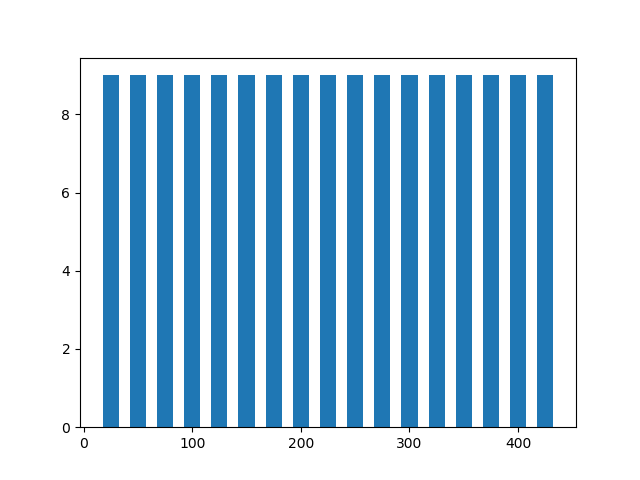

In [77]:
activation = arctan
activation_Der = arctanDerivative
no_inputs = 64
no_tags = 10
no_hidden = 20
iterations = 50
reg = 1


iters = np.arange(25, 450, 25, dtype = np.int)

t1 = initializeWeights(no_inputs, no_hidden)
t2 = initializeWeights(no_hidden, no_tags)
Y_it = np.zeros(len(iters))


j = 0
for i in iters:
    W1, W2 = trainNN(no_inputs, no_hidden, no_tags, i, reg, X_input, Y_input, t1, t2, activation, activation_Der)
    Y_it[j] = (testNN(W1, W2, testSet_X, testSet_Y, activation))
    j = j+1


plt.figure()
fig = plt.bar(iters, Y_it, width = 15)
plt.savefig("relu_precision_iterations")
plt.show()


# Anex
- How many hidden layers should my NN have?
http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-9.html
https://towardsdatascience.com/beginners-ask-how-many-hidden-layers-neurons-to-use-in-artificial-neural-networks-51466afa0d3e
- How many nodes should the hidden layer of my NN have?
http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-10.html